# НИР

## Импорт библиотек

In [7]:
from pathlib import Path
import pandas as pd
import numpy as np
import zipfile
import urllib.request
import shutil
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

## Переменные среды

In [2]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

ZIP_URL = "https://files.consumerfinance.gov/hmda-historic-loan-data/hmda_2017_nationwide_all-records_labels.zip"
ZIP_PATH = DATA_DIR / "hmda_2017_nationwide_all-records_labels.zip"
RAW_CSV_PATH = DATA_DIR / "hmda_2017_nationwide_all-records_labels.csv"

CLEAN_CSV_PATH = DATA_DIR / "hmda_nationwide_2017_purchase_action13_clean.csv"
CLEAN_PARQUET = DATA_DIR / "hmda_nationwide_2017_purchase_action13_clean.parquet"

SENSITIVE_COLS = ["applicant_sex", "applicant_race_1", "applicant_ethnicity"]


## Загрузка датасета

In [69]:
def download_file(url: str, dst: Path, chunk_size: int = 2**20) -> None:
    dst.parent.mkdir(parents=True, exist_ok=True)
    tmp = dst.with_suffix(dst.suffix + ".part")

    print(f"Downloading:\n  {url}\n-> {dst}")
    req = urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"})
    with urllib.request.urlopen(req) as r, open(tmp, "wb") as f:
        total = r.headers.get("Content-Length")
        total = int(total) if total is not None else 0
        downloaded = 0

        while True:
            chunk = r.read(chunk_size)
            if not chunk:
                break
            f.write(chunk)
            downloaded += len(chunk)
            if total:
                print(f"\r  {downloaded/total:6.1%} ({downloaded/1024/1024:.1f} MB)", end="")

    print("\nDownload finished.")
    tmp.replace(dst)

if not RAW_CSV_PATH.exists():
    if not ZIP_PATH.exists():
        download_file(ZIP_URL, ZIP_PATH)

    print(f"Extracting CSV from:\n  {ZIP_PATH}\n-> {DATA_DIR}")
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        csv_members = [n for n in z.namelist() if n.lower().endswith(".csv")]
        if not csv_members:
            raise RuntimeError("ZIP does not contain a CSV file.")
        # Usually there is exactly one CSV:
        member = csv_members[0]
        z.extract(member, DATA_DIR)

        extracted_path = DATA_DIR / member
        # If the CSV is inside a folder or has a different name, normalize it:
        if extracted_path != RAW_CSV_PATH:
            extracted_path.replace(RAW_CSV_PATH)

    print(f"Raw CSV ready: {RAW_CSV_PATH}")
else:
    print(f"Raw CSV already exists: {RAW_CSV_PATH}")

Downloading:
  https://files.consumerfinance.gov/hmda-historic-loan-data/hmda_2017_nationwide_all-records_labels.zip
-> data/hmda_2017_nationwide_all-records_labels.zip
  100.0% (940.3 MB)
Download finished.
Extracting CSV from:
  data/hmda_2017_nationwide_all-records_labels.zip
-> data
Raw CSV ready: data/hmda_2017_nationwide_all-records_labels.csv


## Чистка датасета

In [ ]:
def _pick_raw_csv(path: Path) -> Path:
    """If exact file doesn't exist, try to find a reasonable CSV inside data/."""
    if path.exists():
        return path

    candidates = sorted(DATA_DIR.glob("*.csv"))
    if not candidates:
        raise FileNotFoundError(
            f"Не найдено ни одного CSV в {DATA_DIR.resolve()}. "
            f"Положи туда распакованный HMDA CSV."
        )

    # Prefer file that looks like HMDA labels
    preferred = None
    for c in candidates:
        name = c.name.lower()
        if ("hmda" in name) and ("labels" in name):
            preferred = c
            break
    if preferred is None:
        preferred = candidates[0]

    print(f"[INFO] RAW_CSV не найден по имени. Беру: {preferred}")
    return preferred


def _log_step(name: str, before_n: int, after_n: int) -> None:
    delta = after_n - before_n
    print(f"{name:45s} : {before_n:>10,d} -> {after_n:>10,d}  ({delta:+,d})")


RAW_CSV = _pick_raw_csv(RAW_CSV_PATH)

print(f"[INFO] Reading: {RAW_CSV}")
df = pd.read_csv(
    RAW_CSV,
    dtype=str,          # читаем как строки, дальше сами приводим типы
    low_memory=False,
    na_values=["NA", "N/A", "", "Exempt"]
)

# Normalize columns
df.columns = df.columns.str.strip().str.lower()
n0 = len(df)
print(f"[INFO] Raw shape: {df.shape}")

df = df.replace({"NA": pd.NA, "N/A": pd.NA, "": pd.NA, "Exempt": pd.NA}).infer_objects(copy=False)

required_cols = ["loan_purpose", "action_taken", *SENSITIVE_COLS, "applicant_income_000s"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"В CSV не найдены обязательные колонки: {missing}")

for c in ["loan_purpose", "action_taken", *SENSITIVE_COLS]:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

df["applicant_income_000s"] = pd.to_numeric(df["applicant_income_000s"], errors="coerce")

n = len(df)

# (a) Only home purchase: loan_purpose == 1
before = len(df)
df = df[df["loan_purpose"] == 1]
_log_step("Filter: loan_purpose == 1 (home purchase)", before, len(df))

# (b) Only originated vs denied: action_taken in {1,3}
before = len(df)
df = df[df["action_taken"].isin([1, 3])]
_log_step("Filter: action_taken in {1(originated),3(denied)}", before, len(df))

# (c) Sensitive attributes must be known (strict baseline)
before = len(df)
df = df[df["applicant_sex"].isin([1, 2])]
_log_step("Filter: applicant_sex in {1,2}", before, len(df))

before = len(df)
df = df[df["applicant_ethnicity"].isin([1, 2])]
_log_step("Filter: applicant_ethnicity in {1,2}", before, len(df))

before = len(df)
df = df[df["applicant_race_1"].isin([1, 2, 3, 4, 5])]
_log_step("Filter: applicant_race_1 in {1..5}", before, len(df))

# (d) Income must exist and be positive
before = len(df)
df = df[df["applicant_income_000s"].notna() & (df["applicant_income_000s"] > 0)]
_log_step("Filter: applicant_income_000s is present & > 0", before, len(df))

# Drop exact duplicates (usually few, but safe)
before = len(df)
df = df.drop_duplicates()
_log_step("Drop duplicates (exact row duplicates)", before, len(df))

cols_before = set(df.columns)

# (a) Drop any "*_name" columns (text labels duplicating coded fields)
name_cols = [c for c in df.columns if "_name" in c]
df = df.drop(columns=name_cols, errors="ignore")

# (b) Drop denial reasons (leakage)
df = df.drop(columns=["denial_reason_1", "denial_reason_2", "denial_reason_3"], errors="ignore")

# (c) Drop very sparse additional race columns (can revisit later with multi-hot)
df = df.drop(columns=[
    "applicant_race_2", "applicant_race_3", "applicant_race_4", "applicant_race_5",
    "co_applicant_race_2", "co_applicant_race_3", "co_applicant_race_4", "co_applicant_race_5",
], errors="ignore")

# (d) Drop fully-empty columns if any remained after filtering
df = df.dropna(axis=1, how="all")

cols_after = set(df.columns)
dropped_cols = sorted(list(cols_before - cols_after))
print(f"\n[INFO] Dropped columns: {len(dropped_cols)}")
if dropped_cols:
    print("  " + "\n  ".join(dropped_cols[:50]) + ("" if len(dropped_cols) <= 50 else f"\n  ... +{len(dropped_cols)-50} more"))

NUM_COLS = df.select_dtypes(include=[np.number]).columns.tolist()

for c in NUM_COLS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["y"] = (df["action_taken"] == 1).astype(np.int8)

df["group_sre"] = (
    df[SENSITIVE_COLS]
      .astype("Int64")
      .astype(str)
      .agg("_".join, axis=1)
)

const_cols = [
    "loan_purpose",
    "state_abbr",
    "state_code",
    "as_of_year"
]
print(f"[INFO] Dropping {len(const_cols)} constant numeric columns.")
df = df.drop(columns = const_cols)

df = df.drop(columns=["purchaser_type"])

co_cols = ["co_applicant_ethnicity", "co_applicant_sex", "co_applicant_race_1"]
missing_co = [c for c in co_cols if c not in df.columns]
if missing_co:
    raise KeyError(f"Нет колонок созаявителя: {missing_co}")

co_eth = pd.to_numeric(df["co_applicant_ethnicity"], errors="coerce")
co_sex = pd.to_numeric(df["co_applicant_sex"], errors="coerce")
co_race = pd.to_numeric(df["co_applicant_race_1"], errors="coerce")

all_missing = co_eth.isna() & co_sex.isna() & co_race.isna()
no_coapp = (co_eth == 5) & (co_sex == 5) & (co_race == 8)

# если вдруг все три NaN (маловероятно) — считаем "нет созаявителя" (консервативно)
df["has_coapplicant"] = np.where(all_missing, 0, np.where(no_coapp, 0, 1)).astype(np.int8)

# диагностика (полезно один раз посмотреть)
any_no = (co_eth == 5) | (co_sex == 5) | (co_race == 8)
inconsistent = any_no & (~no_coapp) & (~all_missing)
print("[INFO] has_coapplicant value_counts:")
display(df["has_coapplicant"].value_counts())
print("[INFO] inconsistent co-applicant coding rows:", int(inconsistent.sum()))

# drop ALL co_applicant_* columns
co_drop = [c for c in df.columns if c.startswith("co_applicant_")]
df = df.drop(columns=co_drop, errors="ignore")
print("[INFO] Dropped co_applicant_*:", len(co_drop))

census_cols = [
    "population",
    "minority_population",
    "hud_median_family_income",
    "tract_to_msamd_income",
    "number_of_owner_occupied_units",
    "number_of_1_to_4_family_units",
]

for c in census_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

def safe_div(num, den):
    den = den.replace(0, np.nan)
    return num / den

pop   = df["population"]
units = df["number_of_1_to_4_family_units"]
own   = df["number_of_owner_occupied_units"]

df["units_per_capita"] = safe_div(units, pop)          
df["owner_occ_ratio"]  = safe_div(own, units)

if "hud_median_family_income" in df.columns and "tract_to_msamd_income" in df.columns:
    df["tract_median_income_est"] = df["hud_median_family_income"] * (df["tract_to_msamd_income"] / 100.0)

df = df.drop(columns=census_cols)

df = df.drop(columns=["action_taken"])

df = df.drop(columns=["agency_abbr"])

df = df.drop(columns=["hoepa_status", "lien_status"])


print("\n[INFO] Clean shape:", df.shape)
print("[INFO] y distribution:")
display(df["y"].value_counts())
display(df["y"].value_counts(normalize=True))

print("\n[INFO] Top intersection groups (sex_race_ethnicity):")
display(df["group_sre"].value_counts().head(10))

print(f"\n[INFO] Saving cleaned dataset to:\n  {CLEAN_CSV_PATH}")
df.to_csv(CLEAN_CSV_PATH, index=False)
print("[INFO] Done.")


[INFO] Reading: data/hmda_2017_nationwide_all-records_labels.csv


: 

## Проверка корреляции

In [50]:
df = pd.read_csv(CLEAN_CSV_PATH, low_memory=False)

num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"[INFO] Numeric columns found: {len(num_cols_all)}")
print(num_cols_all)

# 6) Приводим к float (на случай nullable Int/смешанных типов)
Xnum = df[num_cols_all].astype("float64")

# 7) Pearson correlation по всем числовым фичам
corr = Xnum.corr(method="pearson")
print("[INFO] Corr matrix shape:", corr.shape)
display(corr)

# 8) Top correlated pairs (+ сколько наблюдений реально участвовало в расчете пары)
#    counts[i,j] = число строк, где НЕ NaN и i и j
non_na = Xnum.notna().astype(np.int32)
pair_counts = non_na.T @ non_na  # (n_features x n_features)

corr2 = corr.copy()
np.fill_diagonal(corr2.values, np.nan)

stack = corr2.unstack().dropna()
stack = stack[stack.index.get_level_values(0) < stack.index.get_level_values(1)]  # убрать дубли
top = stack.reindex(stack.abs().sort_values(ascending=False).index).head(20)

top_pairs = []
for (a, b), v in top.items():
    top_pairs.append({
        "feature_1": a,
        "feature_2": b,
        "corr": float(v),
        "abs_corr": float(abs(v)),
        "pair_non_null": int(pair_counts.loc[a, b])
    })

top_pairs = pd.DataFrame(top_pairs)
print("[INFO] Top correlated pairs among ALL numeric features:")
display(top_pairs)

[INFO] Numeric columns found: 19
['agency_code', 'loan_type', 'property_type', 'owner_occupancy', 'loan_amount_000s', 'preapproval', 'msamd', 'county_code', 'census_tract_number', 'applicant_ethnicity', 'applicant_race_1', 'applicant_sex', 'applicant_income_000s', 'rate_spread', 'y', 'has_coapplicant', 'units_per_capita', 'owner_occ_ratio', 'tract_median_income_est']
[INFO] Corr matrix shape: (19, 19)


,agency_code,loan_type,property_type,owner_occupancy,loan_amount_000s,preapproval,msamd,county_code,census_tract_number,applicant_ethnicity,applicant_race_1,applicant_sex,applicant_income_000s,rate_spread,y,has_coapplicant,units_per_capita,owner_occ_ratio,tract_median_income_est
agency_code,1.000000,0.035685,-0.020482,-0.032994,0.074490,-0.039137,0.031410,-0.036789,-0.036993,-0.048154,-0.067589,0.005419,0.011571,-0.058610,-0.044794,-0.021062,-0.025451,0.030196,0.074068
loan_type,0.035685,1.000000,-0.080471,-0.190248,-0.055941,-0.073329,0.012366,0.029685,0.034356,-0.055066,0.022282,-0.041022,-0.047965,-0.361424,0.004828,-0.063182,0.002640,-0.041301,-0.166849
property_type,-0.020482,-0.080471,1.000000,-0.024809,-0.097984,0.093157,-0.008776,0.018318,0.086341,-0.005039,0.019467,0.037893,-0.025692,0.608743,-0.300277,-0.016826,0.033670,-0.022346,-0.128445
owner_occupancy,-0.032994,-0.190248,-0.024809,1.000000,-0.010317,0.040607,0.011156,-0.016619,0.018339,0.040170,-0.023338,-0.048623,0.060747,0.000939,0.010815,0.051057,0.092487,-0.008640,-0.056641
loan_amount_000s,0.074490,-0.055941,-0.097984,-0.010317,1.000000,0.008324,0.037098,-0.045105,-0.021457,0.027016,-0.052469,-0.058760,0.629050,-0.227439,0.042644,0.083436,-0.018792,0.054171,0.286993
preapproval,-0.039137,-0.073329,0.093157,0.040607,0.008324,1.000000,0.013180,0.001089,0.019872,0.003171,0.000577,-0.007654,0.006081,0.162194,-0.055452,0.021328,0.007776,0.003916,0.010588
msamd,0.031410,0.012366,-0.008776,0.011156,0.037098,0.013180,1.000000,-0.016367,0.000352,-0.032668,-0.004406,-0.007391,0.003746,-0.030569,0.002500,0.021497,0.005672,0.010165,-0.005626
county_code,-0.036789,0.029685,0.018318,-0.016619,-0.045105,0.001089,-0.016367,1.000000,-0.023413,-0.010509,-0.004033,-0.005803,-0.006658,0.043833,-0.007729,-0.013971,-0.011279,-0.020148,-0.017408
census_tract_number,-0.036993,0.034356,0.086341,0.018339,-0.021457,0.019872,0.000352,-0.023413,1.000000,0.040589,0.017061,-0.014094,-0.003430,0.088937,-0.039166,0.009184,0.065090,-0.030116,-0.015897
applicant_ethnicity,-0.048154,-0.055066,-0.005039,0.040170,0.027016,0.003171,-0.032668,-0.010509,0.040589,1.000000,-0.106249,0.003189,0.019900,0.050246,0.038259,0.033691,0.048077,0.013675,0.125323


[INFO] Top correlated pairs among ALL numeric features:


,feature_1,feature_2,corr,abs_corr,pair_non_null
0,applicant_income_000s,loan_amount_000s,0.629050,0.629050,4236423
1,property_type,rate_spread,0.608743,0.608743,342727
2,loan_type,rate_spread,-0.361424,0.361424,342727
3,property_type,y,-0.300277,0.300277,4236765
4,loan_amount_000s,tract_median_income_est,0.286993,0.286993,4195780
5,loan_amount_000s,rate_spread,-0.227439,0.227439,342720
6,loan_type,owner_occupancy,-0.190248,0.190248,4236765
7,owner_occ_ratio,tract_median_income_est,0.173168,0.173168,4195634
8,applicant_sex,has_coapplicant,-0.171670,0.171670,4236765
9,loan_type,tract_median_income_est,-0.166849,0.166849,4196010


In [51]:
display(df.shape)
display(df.info())

(4236765, 21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4236765 entries, 0 to 4236764
Data columns (total 21 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   respondent_id            object 
 1   agency_code              int64  
 2   loan_type                int64  
 3   property_type            int64  
 4   owner_occupancy          int64  
 5   loan_amount_000s         float64
 6   preapproval              int64  
 7   msamd                    float64
 8   county_code              float64
 9   census_tract_number      float64
 10  applicant_ethnicity      int64  
 11  applicant_race_1         int64  
 12  applicant_sex            int64  
 13  applicant_income_000s    float64
 14  rate_spread              float64
 15  y                        int64  
 16  group_sre                object 
 17  has_coapplicant          int64  
 18  units_per_capita         float64
 19  owner_occ_ratio          float64
 20  tract_median_income_est  float64
dtypes: float

None

In [52]:
display(df.head())

,respondent_id,agency_code,loan_type,property_type,owner_occupancy,loan_amount_000s,preapproval,msamd,county_code,census_tract_number,...,applicant_race_1,applicant_sex,applicant_income_000s,rate_spread,y,group_sre,has_coapplicant,units_per_capita,owner_occ_ratio,tract_median_income_est
0,0000146672,9,1,1,2,185.0,3,40140.0,65.0,432.27,...,2,2,51.0,NaN,0,2_2_2,0,0.235413,0.697074,73318.321350
1,71-0697350,7,1,1,2,38.0,3,45500.0,91.0,210.00,...,5,1,36.0,NaN,0,1_5_2,0,0.417507,0.730689,60785.701294
2,0000451965,9,2,1,1,196.0,3,33874.0,91.0,2036.02,...,5,1,57.0,NaN,1,1_5_2,0,0.358754,0.697881,75811.139374
3,33-0975529,7,2,1,1,82.0,2,NaN,115.0,1003.00,...,5,2,74.0,2.08,1,2_5_2,1,0.526958,0.686053,64621.982101
4,43-1918759,7,2,1,1,144.0,1,41180.0,189.0,2109.24,...,3,2,39.0,NaN,0,2_3_2,0,0.313172,0.742061,65866.951134


In [60]:
df.drop(columns=["rate_spread"])

,respondent_id,agency_code,loan_type,property_type,owner_occupancy,loan_amount_000s,preapproval,msamd,county_code,census_tract_number,...,applicant_sex,applicant_income_000s,y,group_sre,has_coapplicant,units_per_capita,owner_occ_ratio,tract_median_income_est,group_id,rate_spread_missing
0,0000146672,9,1,1,2,185.0,3,40140.0,65.0,432.27,...,2,51.0,0,2_2_2,0,0.235413,0.697074,73318.321350,13,1
1,71-0697350,7,1,1,2,38.0,3,45500.0,91.0,210.00,...,1,36.0,0,1_5_2,0,0.417507,0.730689,60785.701294,9,1
2,0000451965,9,2,1,1,196.0,3,33874.0,91.0,2036.02,...,1,57.0,1,1_5_2,0,0.358754,0.697881,75811.139374,9,1
3,33-0975529,7,2,1,1,82.0,2,NaN,115.0,1003.00,...,2,74.0,1,2_5_2,1,0.526958,0.686053,64621.982101,19,0
4,43-1918759,7,2,1,1,144.0,1,41180.0,189.0,2109.24,...,2,39.0,0,2_3_2,0,0.313172,0.742061,65866.951134,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4236760,0000617677,9,3,1,1,67.0,2,10420.0,153.0,5062.00,...,1,90.0,0,1_3_2,0,0.438618,0.681586,49550.938797,5,1
4236761,0000656733,9,1,1,1,271.0,3,26420.0,157.0,6731.01,...,1,24.0,0,1_2_2,1,0.285921,0.908293,151358.253098,3,1
4236762,0000451965,9,1,1,1,250.0,3,27260.0,109.0,208.05,...,2,48.0,0,2_5_2,1,0.318391,0.876748,108994.926468,19,1
4236763,0000480228,9,1,1,1,495.0,2,16700.0,19.0,46.07,...,2,128.0,1,2_5_2,0,0.299983,0.633877,82931.520630,19,1


# Проверка и чистка от дискриминации

[OVERALL] N=4,236,765 | approve(y=1)=0.8738 | deny(y=0)=0.1262
y
approve(1)    3702195
deny(0)        534570
Name: count, dtype: int64

[GROUP_SRE] groups=20 | approve_rate gap (max-min) = 0.1440

[TOP 15 groups by size]


,n,approve_rate,deny_rate,share
group_sre,,,,
1_5_2,2159580,0.894759,0.105241,0.509724
2_5_2,934584,0.874746,0.125254,0.220589
1_5_1,319990,0.847380,0.152620,0.075527
1_2_2,207181,0.891129,0.108871,0.048901
1_3_2,174325,0.793202,0.206798,0.041146
2_3_2,148638,0.761111,0.238889,0.035083
2_5_1,142603,0.825838,0.174162,0.033658
2_2_2,87148,0.881558,0.118442,0.020569
1_1_2,15874,0.799105,0.200895,0.003747



[TOP 15 lowest approval]


,n,approve_rate,deny_rate,share
group_sre,,,,
2_1_2,9293,0.750780,0.249220,0.002193
2_3_1,3861,0.753432,0.246568,0.000911
2_1_1,2237,0.760840,0.239160,0.000528
2_3_2,148638,0.761111,0.238889,0.035083
1_1_1,4516,0.786094,0.213906,0.001066
1_3_2,174325,0.793202,0.206798,0.041146
1_3_1,5296,0.793240,0.206760,0.001250
2_4_1,1063,0.794920,0.205080,0.000251
1_1_2,15874,0.799105,0.200895,0.003747



[TOP 15 highest approval]


,n,approve_rate,deny_rate,share
group_sre,,,,
1_5_2,2159580,0.894759,0.105241,0.509724
1_2_2,207181,0.891129,0.108871,0.048901
2_2_2,87148,0.881558,0.118442,0.020569
1_4_2,10358,0.875941,0.124059,0.002445
2_5_2,934584,0.874746,0.125254,0.220589
2_4_2,4732,0.858622,0.141378,0.001117
1_2_1,2116,0.853497,0.146503,0.000499
1_5_1,319990,0.847380,0.152620,0.075527
2_2_1,1107,0.843722,0.156278,0.000261


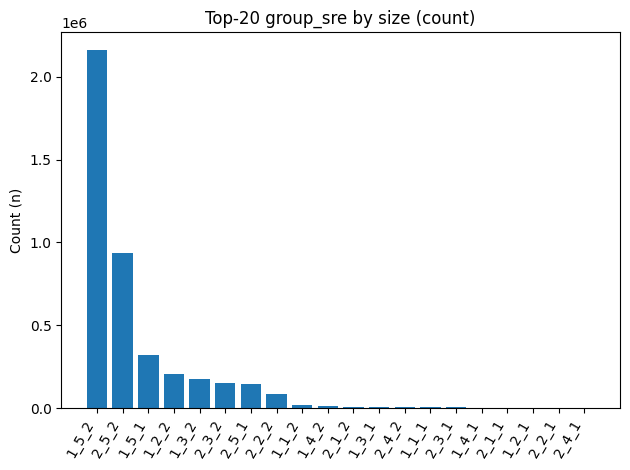

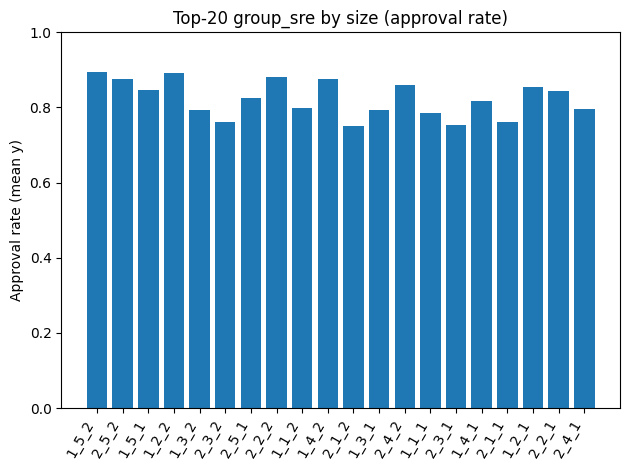

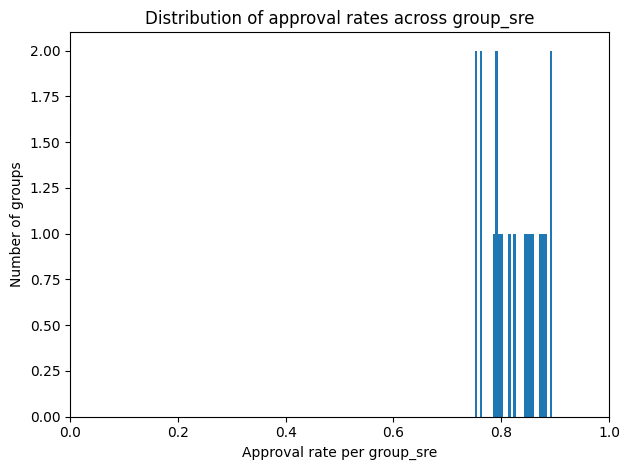

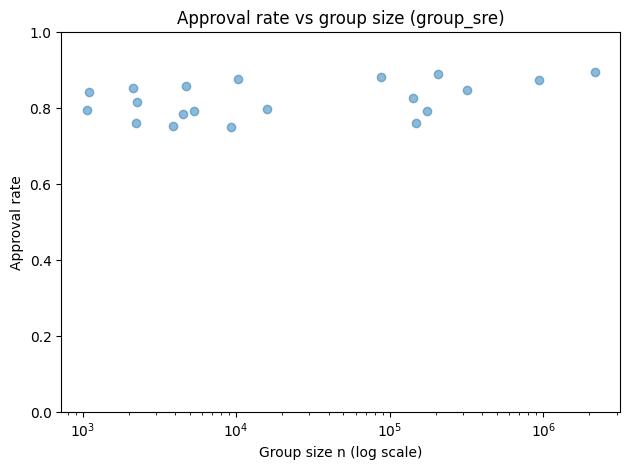


[SEX] groups=2 | approve_rate gap (max-min) = 0.0264


,n,approve_rate,deny_rate
applicant_sex,,,
1,2901499,0.882136,0.117864
2,1335266,0.855767,0.144233


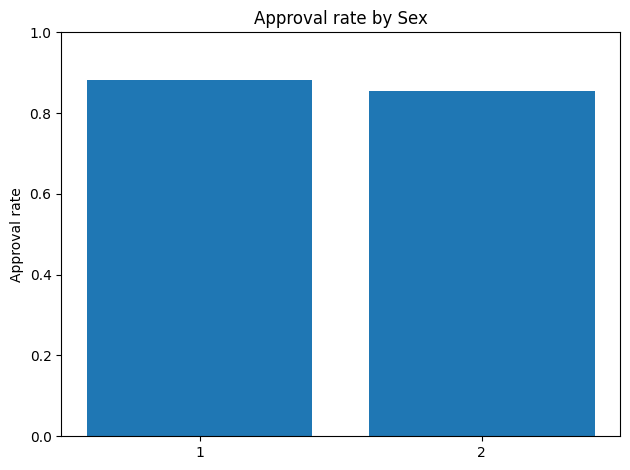

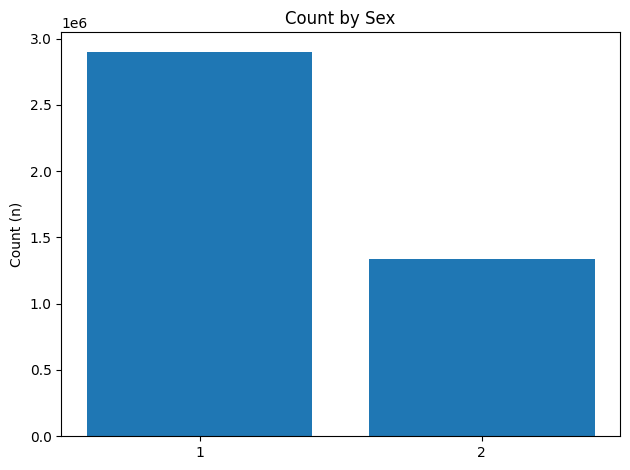


[RACE] groups=5 | approve_rate gap (max-min) = 0.1095


,n,approve_rate,deny_rate
applicant_race_1,,,
5,3556757,0.882474,0.117526
3,332120,0.778378,0.221622
2,297552,0.887882,0.112118
1,31920,0.780514,0.219486
4,18416,0.859470,0.140530


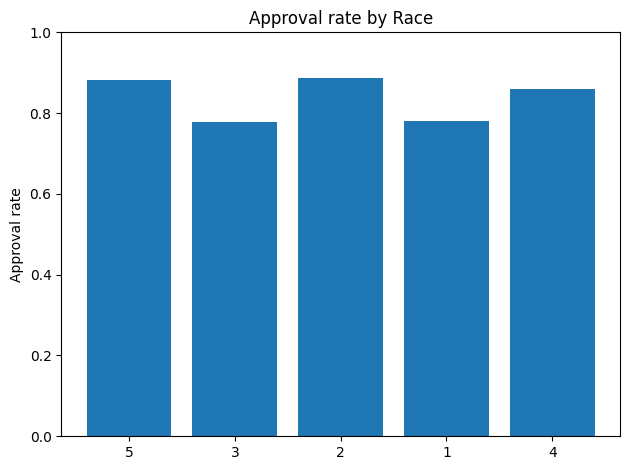

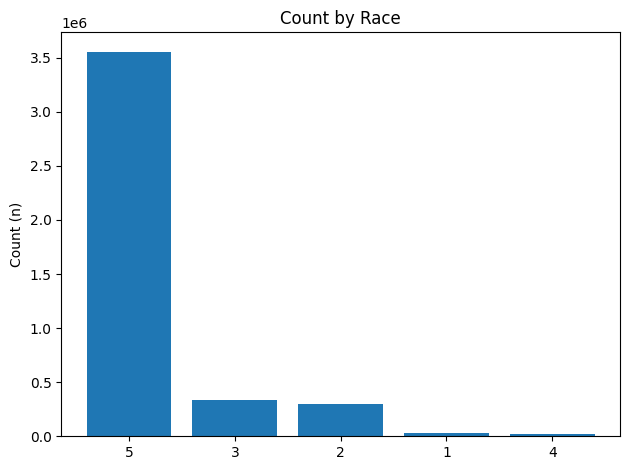


[ETHNICITY] groups=2 | approve_rate gap (max-min) = 0.0399


,n,approve_rate,deny_rate
applicant_ethnicity,,,
2,3751713,0.878394,0.121606
1,485052,0.838496,0.161504


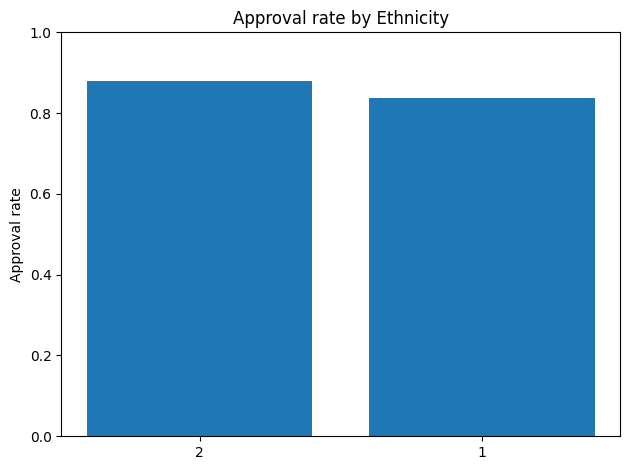

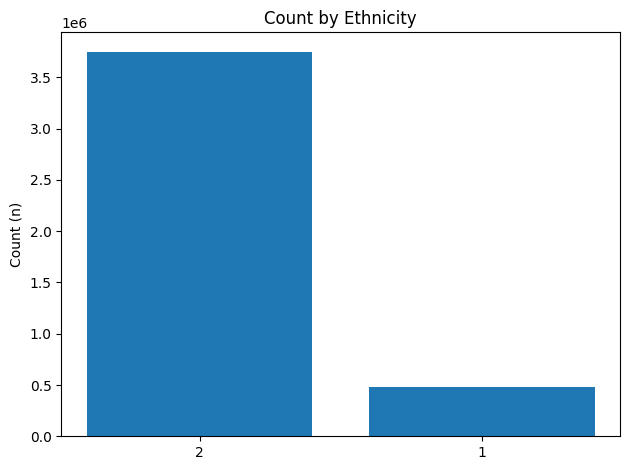

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ====== INPUT ======
# Expecting df_clean to exist in the notebook namespace (clean df BEFORE any split)

TARGET_COL = "y"          # 1=approve, 0=deny
GROUP_COL = "group_sre"   # intersection group label, e.g. "sex_race_eth"

# Optional sensitive components (only for extra breakdown charts, if present)
SENSITIVE_AXES = [
    ("Sex", "applicant_sex"),
    ("Race", "applicant_race_1"),
    ("Ethnicity", "applicant_ethnicity"),
]

# ---- Safety checks / fallback ----
if GROUP_COL not in df.columns:
    # If group_sre is not present but components are, build it
    cols = [c for _, c in SENSITIVE_AXES if c in df.columns]
    if len(cols) == 3:
        df[GROUP_COL] = (
            df[cols[0]].astype("Int64").astype(str) + "_" +
            df[cols[1]].astype("Int64").astype(str) + "_" +
            df[cols[2]].astype("Int64").astype(str)
        )
    else:
        raise ValueError(f"Column '{GROUP_COL}' not found and cannot be constructed (missing sensitive cols).")

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found.")

df[TARGET_COL] = df[TARGET_COL].astype(int)

# ====== 1) TEXT SUMMARY ======
n_total = len(df)
approve_rate = df[TARGET_COL].mean()
deny_rate = 1.0 - approve_rate
print(f"[OVERALL] N={n_total:,} | approve(y=1)={approve_rate:.4f} | deny(y=0)={deny_rate:.4f}")
print(df[TARGET_COL].value_counts().rename({0:"deny(0)", 1:"approve(1)"}))
print()

# ====== 2) GROUP_SRE TABLE ======
g = (
    df.groupby(GROUP_COL)[TARGET_COL]
      .agg(n="count", approve_rate="mean")
      .sort_values("n", ascending=False)
)
g["deny_rate"] = 1.0 - g["approve_rate"]
g["share"] = g["n"] / n_total

gap = float(g["approve_rate"].max() - g["approve_rate"].min())
print(f"[GROUP_SRE] groups={len(g):,} | approve_rate gap (max-min) = {gap:.4f}")
print("\n[TOP 15 groups by size]")
display(g.head(15))
print("\n[TOP 15 lowest approval]")
display(g.sort_values("approve_rate", ascending=True).head(15))
print("\n[TOP 15 highest approval]")
display(g.sort_values("approve_rate", ascending=False).head(15))

# ====== 3) PLOTS ======
# Helper: shorten labels for plotting if too long
def _shorten(s, maxlen=16):
    s = str(s)
    return s if len(s) <= maxlen else s[:maxlen-1] + "…"

# --- Plot A: Top-20 groups by size — counts ---
topN = 20
g_top = g.head(topN).copy()
labels_top = [_shorten(x, 20) for x in g_top.index]

plt.figure()
plt.bar(range(len(g_top)), g_top["n"].values)
plt.xticks(range(len(g_top)), labels_top, rotation=60, ha="right")
plt.ylabel("Count (n)")
plt.title(f"Top-{topN} group_sre by size (count)")
plt.tight_layout()
plt.show()

# --- Plot B: Top-20 groups by size — approval rate ---
plt.figure()
plt.bar(range(len(g_top)), g_top["approve_rate"].values)
plt.xticks(range(len(g_top)), labels_top, rotation=60, ha="right")
plt.ylim(0, 1)
plt.ylabel("Approval rate (mean y)")
plt.title(f"Top-{topN} group_sre by size (approval rate)")
plt.tight_layout()
plt.show()

# --- Plot C: Distribution of approval rates across all groups (histogram) ---
plt.figure()
plt.hist(g["approve_rate"].values, bins=30)
plt.xlim(0, 1)
plt.xlabel("Approval rate per group_sre")
plt.ylabel("Number of groups")
plt.title("Distribution of approval rates across group_sre")
plt.tight_layout()
plt.show()

# --- Plot D: Relationship between group size and approval rate (scatter, log-x) ---
plt.figure()
plt.scatter(g["n"].values, g["approve_rate"].values, alpha=0.5)
plt.xscale("log")
plt.ylim(0, 1)
plt.xlabel("Group size n (log scale)")
plt.ylabel("Approval rate")
plt.title("Approval rate vs group size (group_sre)")
plt.tight_layout()
plt.show()

# ====== 4) OPTIONAL: break down by Sex/Race/Eth separately (if columns exist) ======
for title, col in SENSITIVE_AXES:
    if col not in df.columns:
        continue
    t = df.groupby(col)[TARGET_COL].agg(n="count", approve_rate="mean").sort_values("n", ascending=False)
    t["deny_rate"] = 1.0 - t["approve_rate"]
    print(f"\n[{title.upper()}] groups={len(t):,} | approve_rate gap (max-min) = {float(t['approve_rate'].max()-t['approve_rate'].min()):.4f}")
    display(t)

    # Plot: approval rate per category (sorted by n)
    plt.figure()
    plt.bar(range(len(t)), t["approve_rate"].values)
    plt.xticks(range(len(t)), [str(x) for x in t.index], rotation=0)
    plt.ylim(0, 1)
    plt.ylabel("Approval rate")
    plt.title(f"Approval rate by {title}")
    plt.tight_layout()
    plt.show()

    # Plot: counts per category
    plt.figure()
    plt.bar(range(len(t)), t["n"].values)
    plt.xticks(range(len(t)), [str(x) for x in t.index], rotation=0)
    plt.ylabel("Count (n)")
    plt.title(f"Count by {title}")
    plt.tight_layout()
    plt.show()



## Train/Test split

In [61]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split

# =========================
# 0) Config
# =========================
SEED = 42
TEST_SIZE = 0.20
VAL_SIZE = 0.20  # доля от trainval, т.е. итог: train=0.64, val=0.16, test=0.20


# Batch size: чуть больше на GPU
BATCH_SIZE = 2048 if torch.cuda.is_available() else 512
NUM_WORKERS = 0

torch.manual_seed(SEED)
np.random.seed(SEED)


required = ["y", "group_sre"]
miss = [c for c in required if c not in df.columns]
if miss:
    raise KeyError(f"В датасете нет обязательных колонок: {miss}")

# y -> int 0/1
df["y"] = pd.to_numeric(df["y"], errors="coerce").astype("Int64")
if df["y"].isna().any():
    raise ValueError("В y есть NaN. Проверь формирование таргета.")
df["y"] = df["y"].astype(np.int8)


# =========================
# 2) group_id from group_sre
# =========================
df["group_sre"] = df["group_sre"].astype(str)
df["group_id"], group_levels = pd.factorize(df["group_sre"], sort=True)
num_groups = len(group_levels)
print("[INFO] num_groups (group_sre):", num_groups)

# =========================
# 3) Feature lists
# =========================
# Категориальные (embedding)
cat_cols = [
    # lender / agency / geo
    "respondent_id",
    "agency_code",
    "loan_type",
    "property_type",
    "owner_occupancy",
    "preapproval",
    "msamd",
    "county_code",
    "census_tract_number",
    # sensitive (оставляем как категории — потом решим, подавать ли в модель)
    "applicant_sex",
    "applicant_race_1",
    "applicant_ethnicity",
]

# Числовые
num_cols = [
    "loan_amount_000s",
    "applicant_income_000s",
    "has_coapplicant",
    "units_per_capita",
    "owner_occ_ratio",
    "tract_median_income_est",
]

# Оставляем только реально существующие в df
cat_cols = [c for c in cat_cols if c in df.columns]
num_cols = [c for c in num_cols if c in df.columns]

print("[INFO] cat_cols:", cat_cols)
print("[INFO] num_cols:", num_cols)

# rate_spread_missing (если rate_spread есть)
if "rate_spread" in df.columns and "rate_spread_missing" not in df.columns:
    df["rate_spread_missing"] = pd.isna(df["rate_spread"]).astype(np.int8)
    num_cols.append("rate_spread_missing")
    print("[INFO] Added rate_spread_missing")

# =========================
# 4.1) Train/Test split (stratify by y)
# =========================
trainval_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=df["y"],
)

train_df, val_df = train_test_split(
    trainval_df,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=trainval_df["y"],
)

def _show_split_stats(name, d):
    vc = d["y"].value_counts(normalize=True).sort_index()
    print(f"{name:8s} n={len(d):,d}  y0={vc.get(0,0):.4f}  y1={vc.get(1,0):.4f}")

print("\n[INFO] Split stats (stratified by y):")
_show_split_stats("train", train_df)
_show_split_stats("val",   val_df)
_show_split_stats("test",  test_df)

# =========================
# 4.2) Custom undersampling of class=1 within each group_sre (keep all class=0)
# =========================
SEED = 42
DIV = 5              # делим класс 1 на 5
MIN_KEEP = 50        # минимум примеров класса 1 на группу, чтобы группа не исчезла (можно 1, но лучше >=20-50)

train_df_fit = train_df.copy()  # для fit энкодеров/скейлера (важно!)

train_df_0 = train_df[train_df["y"] == 0]
train_df_1 = train_df[train_df["y"] == 1]

def downsample_1_group(g):
    n = len(g)
    # твой план: n_keep = n//3, но без "обнуления" маленьких групп
    n_keep = max(MIN_KEEP, n // DIV)
    n_keep = min(n_keep, n)  # не больше, чем есть
    return g.sample(n=n_keep, random_state=SEED)

train_df_1_ds = (
    train_df_1
    .groupby("group_sre", group_keys=False)
    .apply(downsample_1_group)
)

train_df = (
    pd.concat([train_df_0, train_df_1_ds], ignore_index=True)
    .sample(frac=1.0, random_state=SEED)
    .reset_index(drop=True)
)

print("[INFO] After custom undersampling:")
_show_split_stats("train", train_df)  # твоя функция
print("[INFO] train size:", len(train_df))

# полезно посмотреть, сколько класса 1 осталось по группам
tmp = train_df[train_df["y"]==1]["group_sre"].value_counts()
print("[INFO] smallest class-1 group count:", int(tmp.min()), "largest:", int(tmp.max()))


# =========================
# 5) Encoders: categories -> int, numerics -> impute+standardize
# =========================
class CatEncoder:
    def __init__(self, cols):
        self.cols = cols
        self.maps = {}
        self.cardinalities = []

    def fit(self, df_fit: pd.DataFrame):
        self.maps = {}
        self.cardinalities = []
        for c in self.cols:
            # Treat everything as string category; missing -> "__NA__"
            s = df_fit[c].astype("string").fillna("__NA__")
            # vocabulary from train
            uniq = pd.Index(s.unique()).astype(str)
            # reserve 0 for UNK
            mapping = {k: i+1 for i, k in enumerate(sorted(uniq))}
            self.maps[c] = mapping
            self.cardinalities.append(len(mapping) + 1)  # +1 for UNK(0)
        return self

    def transform(self, df_tr: pd.DataFrame) -> np.ndarray:
        out = np.zeros((len(df_tr), len(self.cols)), dtype=np.int64)
        for j, c in enumerate(self.cols):
            s = df_tr[c].astype("string").fillna("__NA__").astype(str)
            mp = self.maps[c]
            out[:, j] = np.array([mp.get(v, 0) for v in s], dtype=np.int64)
        return out

class NumScaler:
    def __init__(self, cols):
        self.cols = cols
        self.median = {}
        self.mean = {}
        self.std = {}

    def fit(self, df_fit: pd.DataFrame):
        for c in self.cols:
            x = pd.to_numeric(df_fit[c], errors="coerce")
            med = float(x.median(skipna=True)) if x.notna().any() else 0.0
            x_filled = x.fillna(med)
            mu = float(x_filled.mean())
            sd = float(x_filled.std(ddof=0))
            if not np.isfinite(sd) or sd < 1e-12:
                sd = 1.0
            self.median[c] = med
            self.mean[c] = mu
            self.std[c] = sd
        return self

    def transform(self, df_tr: pd.DataFrame) -> np.ndarray:
        arr = np.zeros((len(df_tr), len(self.cols)), dtype=np.float32)
        for j, c in enumerate(self.cols):
            x = pd.to_numeric(df_tr[c], errors="coerce")
            x = x.fillna(self.median[c]).astype(np.float32)
            arr[:, j] = (x - self.mean[c]) / self.std[c]
        return arr

cat_enc = CatEncoder(cat_cols).fit(train_df_fit)
num_scl = NumScaler(num_cols).fit(train_df_fit)

cat_cardinalities = cat_enc.cardinalities
num_features = len(num_cols)

print("[INFO] cat cardinalities:", cat_cardinalities)
print("[INFO] num_features:", num_features)

# =========================
# 6) Torch Datasets
# =========================
class HMDADataset(Dataset):
    def __init__(self, df_src, cat_arr, num_arr):
        self.y = torch.tensor(df_src["y"].values, dtype=torch.float32)
        self.group = torch.tensor(df_src["group_id"].values, dtype=torch.long)
        self.x_cat = torch.tensor(cat_arr, dtype=torch.long)
        self.x_num = torch.tensor(num_arr, dtype=torch.float32)

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return {
            "x_cat": self.x_cat[idx],
            "x_num": self.x_num[idx],
            "y": self.y[idx],
            "group": self.group[idx],
        }

train_cat = cat_enc.transform(train_df)
val_cat   = cat_enc.transform(val_df)
test_cat  = cat_enc.transform(test_df)

train_num = num_scl.transform(train_df)
val_num   = num_scl.transform(val_df)
test_num  = num_scl.transform(test_df)

train_ds = HMDADataset(train_df, train_cat, train_num)
val_ds   = HMDADataset(val_df,   val_cat,   val_num)
test_ds  = HMDADataset(test_df,  test_cat,  test_num)

# =========================
# 7) Counts for fairness reweighting (TRAIN only)
# =========================
group_counts_np = (
    train_df["group_id"].value_counts()
    .reindex(range(num_groups), fill_value=0)
    .sort_index()
    .values
)
class_counts_np = (
    train_df["y"].value_counts()
    .reindex([0, 1], fill_value=0)
    .sort_index()
    .values
)

group_counts = torch.tensor(group_counts_np, dtype=torch.float32)
class_counts = torch.tensor(class_counts_np, dtype=torch.float32)

print("[INFO] class_counts [y0,y1]:", class_counts_np)
print("[INFO] smallest group count in train:", int(group_counts_np.min()), "largest:", int(group_counts_np.max()))

# =========================
# 8) Group-balanced sampler (train only)
# =========================
# веса = 1/freq(group) -> батчи будут чаще видеть редкие group_sre
inv = 1.0 / np.clip(group_counts_np, 1, None).astype(np.float64)
sample_w = inv[train_df["group_id"].values]
sample_w = sample_w / sample_w.mean()

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_w, dtype=torch.double),
    num_samples=len(train_ds),
    replacement=True
)

pin = torch.cuda.is_available()

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,          # вместо shuffle
    num_workers=NUM_WORKERS,
    pin_memory=pin,
    persistent_workers=(NUM_WORKERS > 0),
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=pin,
    persistent_workers=(NUM_WORKERS > 0),
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=pin,
    persistent_workers=(NUM_WORKERS > 0),
)

print("[INFO] loaders ready:",
      f"train={len(train_ds):,d}, val={len(val_ds):,d}, test={len(test_ds):,d}",
      f"batch_size={BATCH_SIZE}")


[INFO] num_groups (group_sre): 20
[INFO] cat_cols: ['respondent_id', 'agency_code', 'loan_type', 'property_type', 'owner_occupancy', 'preapproval', 'msamd', 'county_code', 'census_tract_number', 'applicant_sex', 'applicant_race_1', 'applicant_ethnicity']
[INFO] num_cols: ['loan_amount_000s', 'applicant_income_000s', 'has_coapplicant', 'units_per_capita', 'owner_occ_ratio', 'tract_median_income_est']

[INFO] Split stats (stratified by y):
train    n=2,711,529  y0=0.1262  y1=0.8738
val      n=677,883  y0=0.1262  y1=0.8738
test     n=847,353  y0=0.1262  y1=0.8738


/tmp/ipykernel_1015/719209862.py:133: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(downsample_1_group)


[INFO] After custom undersampling:
train    n=815,999  y0=0.4193  y1=0.5807
[INFO] train size: 815999
[INFO] smallest class-1 group count: 110 largest: 247291
[INFO] cat cardinalities: [5467, 7, 5, 3, 4, 4, 544, 326, 23592, 3, 6, 3]
[INFO] num_features: 6
[INFO] class_counts [y0,y1]: [342125 473874]
[INFO] smallest group count in train: 232 largest: 392800
[INFO] loaders ready: train=815,999, val=677,883, test=847,353 batch_size=2048


# Модель

In [62]:
def default_emb_dim(cardinality: int) -> int:
    """
    Эвристика размера эмбеддинга (похожа на fastai):
    - растёт медленно
    - ограничена сверху
    """
    return int(min(64, round(1.6 * (cardinality ** 0.56))))

class TabularNet(nn.Module):
    """
    Модель для табличных данных:
    - категориальные фичи -> embeddings
    - числовые фичи -> нормализация
    - concat -> MLP -> 1 логит (binary classification)
    
    x_cat: LongTensor [B, n_cat], значения 0..(card_i-1)
    x_num: FloatTensor [B, n_num]
    """
    def __init__(
        self,
        cat_cardinalities: list[int],
        num_features: int,
        emb_dims: list[int] | None = None,
        emb_dropout: float = 0.05,
        hidden_dims: tuple[int, ...] = (256, 128),
        mlp_dropout: float = 0.15,
        activation: str = "relu",
        use_batchnorm: bool = True,
    ):
        super().__init__()
        self.cat_cardinalities = cat_cardinalities
        self.num_features = num_features

        if emb_dims is None:
            emb_dims = [default_emb_dim(c) for c in cat_cardinalities]
        assert len(emb_dims) == len(cat_cardinalities)

        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=card, embedding_dim=dim)
            for card, dim in zip(cat_cardinalities, emb_dims)
        ])
        self.emb_dropout = nn.Dropout(emb_dropout) if emb_dropout > 0 else nn.Identity()

        self.num_bn = nn.BatchNorm1d(num_features) if (use_batchnorm and num_features > 0) else nn.Identity()

        in_dim = sum(emb_dims) + num_features

        layers: list[nn.Module] = []
        prev = in_dim

        act_layer: nn.Module
        if activation.lower() == "relu":
            act_layer = nn.ReLU()
        elif activation.lower() == "gelu":
            act_layer = nn.GELU()
        else:
            raise ValueError("activation must be 'relu' or 'gelu'")

        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(act_layer)
            if mlp_dropout > 0:
                layers.append(nn.Dropout(mlp_dropout))
            prev = h

        self.mlp = nn.Sequential(*layers) if layers else nn.Identity()
        self.out = nn.Linear(prev, 1)

        # Инициализация (обычно даёт более стабильный старт)
        for emb in self.embeddings:
            nn.init.normal_(emb.weight, mean=0.0, std=0.01)

    def forward(self, x_cat: torch.Tensor, x_num: torch.Tensor) -> torch.Tensor:
        # x_cat: [B, n_cat]
        if len(self.embeddings) > 0:
            embs = []
            for i, emb in enumerate(self.embeddings):
                embs.append(emb(x_cat[:, i]))
            x = torch.cat(embs, dim=1)
            x = self.emb_dropout(x)
        else:
            x = torch.empty((x_num.size(0), 0), device=x_num.device)

        if self.num_features > 0:
            x_num = self.num_bn(x_num)
            x = torch.cat([x, x_num], dim=1)

        x = self.mlp(x)
        logits = self.out(x).squeeze(1)  # [B]
        return logits


# Lightning module

In [63]:
import pytorch_lightning as pl

def focal_loss_with_logits(
    logits: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2.0,
    reduction: str = "mean",
) -> torch.Tensor:
    """
    Focal Loss для бинарной классификации через logits.
    targets: 0/1 float tensor
    """
    targets = targets.float()
    logits = logits.float()

    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
    p = torch.sigmoid(logits)
    pt = torch.where(targets == 1.0, p, 1.0 - p)  # prob of the true class

    focal = (1.0 - pt).pow(gamma)

    if alpha is not None:
        at = torch.where(targets == 1.0, torch.tensor(alpha, device=logits.device), torch.tensor(1.0 - alpha, device=logits.device))
        loss = at * focal * bce
    else:
        loss = focal * bce

    if reduction == "mean":
        return loss.mean()
    if reduction == "sum":
        return loss.sum()
    return loss  # "none"

class HMDALitModule(pl.LightningModule):
    """
    LightningModule для бинарной классификации с fairness через group_sre.

    fairness_strategy:
      - "group_dro" : GroupDRO (min worst-group loss) по group_sre
      - "reweight"  : взвешивание по inv_freq(group) * inv_freq(class)
      - "none"      : обычное обучение

    Ожидаемый batch:
      batch["x_cat"]  -> LongTensor [B, n_cat]
      batch["x_num"]  -> FloatTensor [B, n_num]
      batch["y"]      -> FloatTensor [B] (0/1)
      batch["group"]  -> LongTensor [B] (0..G-1)  индекс group_sre
    """

    def __init__(
        self,
        model: nn.Module,
        num_groups: int,
        group_counts: torch.Tensor | None = None,   # [G] counts in TRAIN
        class_counts: torch.Tensor | None = None,   # [2] counts in TRAIN
        fairness_strategy: str = "group_dro",
        # focal params
        focal_alpha: float = 0.25,
        focal_gamma: float = 2.0,
        # optional extra class weighting (usually OFF with focal)
        use_pos_weight: bool = False,
        # optimization
        lr: float = 3e-3,
        weight_decay: float = 1e-4,
        use_onecycle: bool = True,
        # GroupDRO params
        dro_eta: float = 0.01,
        dro_clip: float = 10.0,
        # metrics / thresholding
        threshold: float = 0.5,
        threshold_grid_steps: int = 101,  # для val_f1_best
        # loss mixing
        macro_f1_lambda: float = 0.5,  # доля soft-macroF1 в лоссе
        neg_weight: float = 1.0,       # вес класса 0 в BCE (штраф за FP по 0)
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model

        self.num_groups = int(num_groups)
        self.fairness_strategy = str(fairness_strategy)

        self.focal_alpha = float(focal_alpha)
        self.focal_gamma = float(focal_gamma)
        self.use_pos_weight = bool(use_pos_weight)

        self.lr = float(lr)
        self.weight_decay = float(weight_decay)
        self.use_onecycle = bool(use_onecycle)

        self.dro_eta = float(dro_eta)
        self.dro_clip = float(dro_clip)

        self.threshold = float(threshold)
        self.threshold_grid_steps = int(threshold_grid_steps)
        self.macro_f1_lambda = float(macro_f1_lambda)
        self.neg_weight = float(neg_weight)

        # --- counts ---
        if class_counts is not None:
            cc = class_counts.float()
            # pos_weight for BCE: weight for positive class = N_neg / N_pos
            n0 = cc[0].clamp(min=1.0)
            n1 = cc[1].clamp(min=1.0)
            pos_w = (n0 / n1).float()
            self.register_buffer("pos_weight", pos_w)  # scalar tensor
        else:
            self.register_buffer("pos_weight", torch.tensor(1.0))

        # ---- group inverse-frequency weights (нужны только для strategy="reweight") ----
        if group_counts is not None:
            gc = group_counts.float()
            inv = 1.0 / torch.clamp(gc, min=1.0)
            inv = inv / torch.clamp(inv.mean(), min=1e-12)
            self.register_buffer("group_inv_freq", inv)
        else:
            self.register_buffer("group_inv_freq", torch.ones(self.num_groups))

        # ---- GroupDRO weights over groups ----
        if self.fairness_strategy == "group_dro":
            w = torch.ones(self.num_groups, dtype=torch.float32)
            w = w / w.sum()
            self.register_buffer("dro_w", w)

        # ---- buffers for validation fairness stats ----
        self._init_val_buffers()
        self._init_val_pred_buffers()

    # -------------------------
    # buffers
    # -------------------------
    def _init_val_buffers(self):
        self.register_buffer("val_n", torch.zeros(self.num_groups))
        self.register_buffer("val_pred_pos", torch.zeros(self.num_groups))
        self.register_buffer("val_tp", torch.zeros(self.num_groups))
        self.register_buffer("val_fp", torch.zeros(self.num_groups))
        self.register_buffer("val_tn", torch.zeros(self.num_groups))
        self.register_buffer("val_fn", torch.zeros(self.num_groups))

    def _init_val_pred_buffers(self):
        # будем копить logits и y на валидации, чтобы подобрать порог по F1
        self.val_logits = []
        self.val_y = []

    def on_validation_epoch_start(self):
        for name in ["val_n", "val_pred_pos", "val_tp", "val_fp", "val_tn", "val_fn"]:
            getattr(self, name).zero_()
        self.val_logits = []
        self.val_y = []

    # -------------------------
    # helpers
    # -------------------------
    def forward(self, x_cat: torch.Tensor, x_num: torch.Tensor) -> torch.Tensor:
        return self.model(x_cat, x_num)
    
    def _focal_per_sample(self, logits: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # focal loss reduction="none"
        y = y.float()
        logits = logits.float()

        bce = F.binary_cross_entropy_with_logits(logits, y, reduction="none")
        p = torch.sigmoid(logits)
        pt = torch.where(y == 1.0, p, 1.0 - p)
        focal = (1.0 - pt).pow(self.focal_gamma)

        alpha = self.focal_alpha
        at = torch.where(y == 1.0, torch.tensor(alpha, device=logits.device), torch.tensor(1.0 - alpha, device=logits.device))
        loss = at * focal * bce

        # optional: additional pos_weight (usually not needed if alpha tuned)
        if self.use_pos_weight:
            pw = self.pos_weight.to(device=logits.device)
            # весим положительный класс
            loss = torch.where(y == 1.0, loss * pw, loss)

        return loss  # [B]
    
    def _soft_f1_from_probs(self, p: torch.Tensor, y: torch.Tensor, w: torch.Tensor | None = None, eps: float = 1e-8):
        """
        Soft F1 (Dice) для бинарного класса "1" по вероятностям p = sigmoid(logits).
        p, y: [B]
        w: [B] или None
        """
        y = y.float()
        p = p.float()
        if w is None:
            w = torch.ones_like(y)

        # soft confusion (взвешенное)
        tp = torch.sum(w * p * y)
        fp = torch.sum(w * p * (1.0 - y))
        fn = torch.sum(w * (1.0 - p) * y)

        soft_f1 = (2.0 * tp) / (2.0 * tp + fp + fn + eps)
        return soft_f1

    def _soft_macro_f1_from_logits(self, logits: torch.Tensor, y: torch.Tensor, w: torch.Tensor | None = None, eps: float = 1e-8):
        """
        Soft macro-F1 = 0.5*(SoftF1(class1) + SoftF1(class0)).
        class0 считается как F1 для y0=1-y и p0=1-p
        """
        p = torch.sigmoid(logits).view(-1)
        y = y.view(-1).float()
        if w is not None:
            w = w.view(-1).float()

        f1_1 = self._soft_f1_from_probs(p, y, w=w, eps=eps)

        p0 = 1.0 - p
        y0 = 1.0 - y
        f1_0 = self._soft_f1_from_probs(p0, y0, w=w, eps=eps)

        macro = 0.5 * (f1_0 + f1_1)
        return macro, f1_0, f1_1

    def _macro_f1_loss(self, logits: torch.Tensor, y: torch.Tensor, w: torch.Tensor | None = None):
        macro, f1_0, f1_1 = self._soft_macro_f1_from_logits(logits, y, w=w, eps=1e-8)
        loss = 1.0 - macro
        return loss, macro, f1_0, f1_1
    
    def _weighted_bce_logits(self, logits: torch.Tensor, y: torch.Tensor, w0: float, w1: float = 1.0):
        y = y.float()
        bce = F.binary_cross_entropy_with_logits(logits, y, reduction="none")
        w = torch.where(y == 0.0,
                        torch.tensor(w0, device=logits.device, dtype=logits.dtype),
                        torch.tensor(w1, device=logits.device, dtype=logits.dtype))
        return (w * bce).mean()



    # -------------------------
    # Train
    # -------------------------
    def training_step(self, batch, batch_idx):
        x_cat = batch["x_cat"]
        x_num = batch["x_num"]
        y = batch["y"].view(-1).float()
        group = batch["group"].long()

        logits = self(x_cat, x_num).view(-1)

        # ---- ВЕСА (только если strategy="reweight") ----
        if self.fairness_strategy == "reweight":
            wg = self.group_inv_freq[group].float()
            wg = wg / torch.clamp(wg.mean(), min=1e-6)   # нормализация
        else:
            wg = None

        bce = self._weighted_bce_logits(logits, y, w0=self.neg_weight, w1=1.0)

        # --- soft macro-F1 часть ---
        macro_loss, macro_soft, f1_0_soft, f1_1_soft = self._macro_f1_loss(logits, y, w=wg)

        # --- общий loss ---
        lam = self.macro_f1_lambda
        loss = (1.0 - lam) * bce + lam * macro_loss

        if self.fairness_strategy == "group_dro":
            group_loss = torch.zeros(self.num_groups, device=self.device, dtype=logits.dtype)
            present = torch.zeros(self.num_groups, device=self.device, dtype=torch.bool)

            for g in range(self.num_groups):
                m = (group == g)
                if not torch.any(m):
                    continue
                present[g] = True
                lg = logits[m]
                yg = y[m]

                bce_g = self._weighted_bce_logits(lg, yg, w0=self.neg_weight, w1=1.0)
                macro_loss_g, _, _, _ = self._macro_f1_loss(lg, yg, w=None)
                loss_g = (1.0 - lam) * bce_g + lam * macro_loss_g
                group_loss[g] = loss_g

            # нормируем веса только по присутствующим группам
            w = self.dro_w.detach().clone().to(dtype=logits.dtype)
            w = w * present.float()
            w = w / torch.clamp(w.sum(), min=1e-12)

            loss = torch.sum(w * group_loss)

            # обновление dro_w
            with torch.no_grad():
                gl = torch.clamp(group_loss.detach(), min=0.0, max=self.dro_clip)
                new_w = self.dro_w * torch.exp(self.dro_eta * gl.float())
                new_w = new_w * present.float()
                new_w = new_w / torch.clamp(new_w.sum(), min=1e-12)
                self.dro_w.copy_(new_w)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_soft_macro_f1", macro_soft, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_soft_f1_0", f1_0_soft, on_step=False, on_epoch=True)
        self.log("train_soft_f1_1", f1_1_soft, on_step=False, on_epoch=True)

        return loss

    # -------------------------
    # Validation
    # -------------------------
    def validation_step(self, batch, batch_idx):
        x_cat = batch["x_cat"]
        x_num = batch["x_num"]
        y = batch["y"]
        group = batch["group"].long()

        logits = self(x_cat, x_num)

        # ДОБАВЬ ВОТ ЭТО:
        wg = None
        if self.fairness_strategy == "reweight":
            wg = self.group_inv_freq[group].float()
            wg = wg / torch.clamp(wg.mean(), min=1e-6)
        bce = self._weighted_bce_logits(logits, y, w0=self.neg_weight, w1=1.0)

        # --- soft macro-F1 часть ---
        macro_loss, macro_soft, f1_0_soft, f1_1_soft = self._macro_f1_loss(logits, y, w=wg)

        # --- общий loss ---
        lam = self.macro_f1_lambda
        loss = (1.0 - lam) * bce + lam * macro_loss

        prob = torch.sigmoid(logits)
        pred = (prob >= self.threshold).long()
        y_long = y.long()

        acc = (pred == y_long).float().mean()
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_step=False, on_epoch=True)

        # stash for threshold tuning
        self.val_logits.append(logits.detach().float().cpu())
        self.val_y.append(y.detach().float().cpu())

        # fairness stats at fixed threshold
        ones = torch.ones_like(y_long, dtype=torch.float32)

        self.val_n.scatter_add_(0, group, ones)
        self.val_pred_pos.scatter_add_(0, group, (pred == 1).float())

        tp = ((pred == 1) & (y_long == 1)).float()
        fp = ((pred == 1) & (y_long == 0)).float()
        tn = ((pred == 0) & (y_long == 0)).float()
        fn = ((pred == 0) & (y_long == 1)).float()

        self.val_tp.scatter_add_(0, group, tp)
        self.val_fp.scatter_add_(0, group, fp)
        self.val_tn.scatter_add_(0, group, tn)
        self.val_fn.scatter_add_(0, group, fn)

    def on_validation_epoch_end(self):
        eps = 1e-9

        # ---- fairness gaps @ fixed self.threshold ----
        n = self.val_n
        mask_n = n > 0
        dp = self.val_pred_pos / (n + eps)

        denom_pos = self.val_tp + self.val_fn
        denom_neg = self.val_fp + self.val_tn
        mask_pos = denom_pos > 0
        mask_neg = denom_neg > 0

        tpr = self.val_tp / (denom_pos + eps)
        fpr = self.val_fp / (denom_neg + eps)

        dp_gap = (dp[mask_n].max() - dp[mask_n].min()) if mask_n.any() else torch.tensor(0.0, device=self.device)
        tpr_gap = (tpr[mask_pos].max() - tpr[mask_pos].min()) if mask_pos.any() else torch.tensor(0.0, device=self.device)
        fpr_gap = (fpr[mask_neg].max() - fpr[mask_neg].min()) if mask_neg.any() else torch.tensor(0.0, device=self.device)

        self.log("val_dp_gap", dp_gap, prog_bar=True)
        self.log("val_tpr_gap", tpr_gap, prog_bar=True)
        self.log("val_fpr_gap", fpr_gap, prog_bar=True)

        # ---- global F1 metrics with threshold tuning on val ----
        logits = torch.cat(self.val_logits, dim=0).numpy()
        y = torch.cat(self.val_y, dim=0).numpy().astype(int)
        probs = 1.0 / (1.0 + np.exp(-logits))  # sigmoid

        # compute F1 at fixed threshold
        pred_fixed = (probs >= self.threshold).astype(int)

        # f1 for class 1
        tp = ((pred_fixed == 1) & (y == 1)).sum()
        fp = ((pred_fixed == 1) & (y == 0)).sum()
        fn = ((pred_fixed == 0) & (y == 1)).sum()
        prec1 = tp / (tp + fp + 1e-12)
        rec1 = tp / (tp + fn + 1e-12)
        f1_1 = 2 * prec1 * rec1 / (prec1 + rec1 + 1e-12)

        # f1 for class 0 (treat 0 as positive)
        tp0 = ((pred_fixed == 0) & (y == 0)).sum()
        fp0 = ((pred_fixed == 0) & (y == 1)).sum()
        fn0 = ((pred_fixed == 1) & (y == 0)).sum()
        prec0 = tp0 / (tp0 + fp0 + 1e-12)
        rec0 = tp0 / (tp0 + fn0 + 1e-12)
        f1_0 = 2 * prec0 * rec0 / (prec0 + rec0 + 1e-12)

        macro_f1 = 0.5 * (f1_0 + f1_1)

        self.log("val_f1_1@thr", torch.tensor(f1_1, device=self.device), prog_bar=True)
        self.log("val_f1_0@thr", torch.tensor(f1_0, device=self.device), prog_bar=True)
        self.log("val_macro_f1@thr", torch.tensor(macro_f1, device=self.device), prog_bar=True)

        # best F1(1) over threshold grid (быстро и стабильно)
        thr_grid = np.linspace(0.01, 0.99, self.threshold_grid_steps)
        best_macro = -1.0
        best_thr = 0.5

        for t in thr_grid:
            pred = (probs >= t).astype(int)

            # f1_1
            tp = ((pred == 1) & (y == 1)).sum()
            fp = ((pred == 1) & (y == 0)).sum()
            fn = ((pred == 0) & (y == 1)).sum()
            prec1 = tp / (tp + fp + 1e-12)
            rec1  = tp / (tp + fn + 1e-12)
            f1_1  = 2 * prec1 * rec1 / (prec1 + rec1 + 1e-12)

            # f1_0 (0 как positive)
            tp0 = ((pred == 0) & (y == 0)).sum()
            fp0 = ((pred == 0) & (y == 1)).sum()
            fn0 = ((pred == 1) & (y == 0)).sum()
            prec0 = tp0 / (tp0 + fp0 + 1e-12)
            rec0  = tp0 / (tp0 + fn0 + 1e-12)
            f1_0  = 2 * prec0 * rec0 / (prec0 + rec0 + 1e-12)

            macro = 0.5 * (f1_0 + f1_1)

            if macro > best_macro:
                best_macro = macro
                best_thr = t

        self.log("val_macro_f1_best", torch.tensor(best_macro, device=self.device), prog_bar=True)
        self.log("val_thr_best", torch.tensor(best_thr, device=self.device), prog_bar=False)

        self.threshold = float(best_thr)
    # -------------------------
    # optim
    # -------------------------
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        if self.use_onecycle and getattr(self, "trainer", None) is not None:
            total_steps = getattr(self.trainer, "estimated_stepping_batches", None)
            if total_steps is not None and total_steps > 0:
                sch = torch.optim.lr_scheduler.OneCycleLR(
                    opt,
                    max_lr=self.lr,
                    total_steps=total_steps,
                    pct_start=0.1,
                    anneal_strategy="cos",
                    div_factor=10.0,
                    final_div_factor=100.0,
                )
                return {"optimizer": opt, "lr_scheduler": {"scheduler": sch, "interval": "step"}}

        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2)
        return {"optimizer": opt, "lr_scheduler": {"scheduler": sch, "monitor": "val_loss"}}

In [64]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger

# Для ускорения на GPU (если есть)
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")

pl.seed_everything(42, workers=True)

n0 = float(class_counts[0])
n1 = float(class_counts[1])
neg_weight = n1 / max(n0, 1.0)

# =========================
# 1) Build model
# =========================
net = TabularNet(
    cat_cardinalities=cat_cardinalities,
    num_features=num_features,
    hidden_dims=(512, 256, 128),   # чуть мощнее базового
    emb_dropout=0.05,
    mlp_dropout=0.20,
    activation="relu",
    use_batchnorm=True,
)

lit = HMDALitModule(
    model=net,
    num_groups=num_groups,
    group_counts=group_counts,
    class_counts=class_counts,
    fairness_strategy="group_dro",
    macro_f1_lambda=0.5,
    neg_weight=neg_weight,
    focal_alpha=0.25,
    focal_gamma=2.0,
    use_pos_weight=False,
    lr=3e-3,
    weight_decay=1e-4,
    use_onecycle=True,
    dro_eta=0.01,
    dro_clip=10.0,
    threshold=0.5,
    threshold_grid_steps=101,
)

# =========================
# 2) Trainer (progress bar + callbacks)
# =========================
callbacks = [
    TQDMProgressBar(refresh_rate=20),  # progress bar
    ModelCheckpoint(
        monitor="val_macro_f1_best",
        mode="max",
        save_top_k=1,
        filename="best-{epoch:02d}-{val_loss:.4f}",
    ),
    EarlyStopping(
        monitor="val_macro_f1_best",
        mode="max",
        patience=5,     # если val_macro_f1_best не улучшается 5 эпох — стоп
        verbose=True,
    ),
    LearningRateMonitor(logging_interval="step"),
]

logger = CSVLogger("logs", name="hmda_lightning")

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices="auto",
    precision="16-mixed" if torch.cuda.is_available() else 32,
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=50,
    enable_progress_bar=True,
    deterministic=True,
    gradient_clip_val=1.0,
)

trainer.fit(lit, train_dataloaders=train_loader, val_dataloaders=val_loader)

# =========================
# 3) Evaluate on test (через validate, чтобы использовать уже реализованные fairness-метрики)
# =========================
print("\n[INFO] Best checkpoint:", trainer.checkpoint_callback.best_model_path)
best_path = trainer.checkpoint_callback.best_model_path
best_lit = HMDALitModule.load_from_checkpoint(best_path, model=net)
trainer.validate(best_lit, dataloaders=test_loader, verbose=True)


Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/mark/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/mark/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | TabularNet | 2.2 M  | train
---------------------------------------------
2.2 M     Trainable params
0

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 45.42it/s]

/home/mark/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 399/399 [00:43<00:00,  9.27it/s, v_num=17, train_loss_step=0.392]

/tmp/ipykernel_1015/2419213157.py:379: RuntimeWarning: overflow encountered in exp
  probs = 1.0 / (1.0 + np.exp(-logits))  # sigmoid


Epoch 0: 100%|██████████| 399/399 [00:52<00:00,  7.64it/s, v_num=17, train_loss_step=0.392, val_loss=0.517, val_acc=0.877, val_dp_gap=0.229, val_tpr_gap=0.170, val_fpr_gap=0.515, val_f1_1@thr=0.934, val_f1_0@thr=0.0561, val_macro_f1@thr=0.495, val_macro_f1_best=0.663, train_loss_epoch=0.424, train_soft_macro_f1=0.737]

Metric val_macro_f1_best improved. New best score: 0.663


Epoch 1: 100%|██████████| 399/399 [00:52<00:00,  7.58it/s, v_num=17, train_loss_step=0.440, val_loss=0.500, val_acc=0.859, val_dp_gap=0.366, val_tpr_gap=0.322, val_fpr_gap=0.438, val_f1_1@thr=0.920, val_f1_0@thr=0.406, val_macro_f1@thr=0.663, val_macro_f1_best=0.664, train_loss_epoch=0.415, train_soft_macro_f1=0.832] 

Metric val_macro_f1_best improved by 0.000 >= min_delta = 0.0. New best score: 0.664


Epoch 2: 100%|██████████| 399/399 [00:52<00:00,  7.65it/s, v_num=17, train_loss_step=0.457, val_loss=0.501, val_acc=0.855, val_dp_gap=0.412, val_tpr_gap=0.354, val_fpr_gap=0.461, val_f1_1@thr=0.917, val_f1_0@thr=0.415, val_macro_f1@thr=0.666, val_macro_f1_best=0.667, train_loss_epoch=0.443, train_soft_macro_f1=0.827]

Metric val_macro_f1_best improved by 0.004 >= min_delta = 0.0. New best score: 0.667


Epoch 4: 100%|██████████| 399/399 [00:54<00:00,  7.36it/s, v_num=17, train_loss_step=0.486, val_loss=0.494, val_acc=0.859, val_dp_gap=0.308, val_tpr_gap=0.277, val_fpr_gap=0.418, val_f1_1@thr=0.920, val_f1_0@thr=0.416, val_macro_f1@thr=0.668, val_macro_f1_best=0.668, train_loss_epoch=0.437, train_soft_macro_f1=0.776]

Metric val_macro_f1_best improved by 0.001 >= min_delta = 0.0. New best score: 0.668


Epoch 9: 100%|██████████| 399/399 [00:50<00:00,  7.96it/s, v_num=17, train_loss_step=0.472, val_loss=0.506, val_acc=0.857, val_dp_gap=0.362, val_tpr_gap=0.305, val_fpr_gap=0.449, val_f1_1@thr=0.919, val_f1_0@thr=0.405, val_macro_f1@thr=0.662, val_macro_f1_best=0.662, train_loss_epoch=0.446, train_soft_macro_f1=0.744]

Monitored metric val_macro_f1_best did not improve in the last 5 records. Best score: 0.668. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 399/399 [00:50<00:00,  7.96it/s, v_num=17, train_loss_step=0.472, val_loss=0.506, val_acc=0.857, val_dp_gap=0.362, val_tpr_gap=0.305, val_fpr_gap=0.449, val_f1_1@thr=0.919, val_f1_0@thr=0.405, val_macro_f1@thr=0.662, val_macro_f1_best=0.662, train_loss_epoch=0.446, train_soft_macro_f1=0.744]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]




[INFO] Best checkpoint: logs/hmda_lightning/version_17/checkpoints/best-epoch=04-val_loss=0.4943.ckpt
Validation DataLoader 0: 100%|██████████| 414/414 [00:11<00:00, 36.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7792702913284302
       val_dp_gap           0.3133704662322998
      val_f1_0@thr          0.40132728354801755
      val_f1_1@thr           0.864637806144542
       val_fpr_gap          0.3040456771850586
        val_loss            0.4934524893760681
    val_macro_f1@thr        0.6329825448462798
    val_macro_f1_best       0.6678496077584467
      val_thr_best                0.2648
       val_tpr_gap          0.30227965116500854
─────────────────────────────────────────────────────────────────────

[{'val_loss': 0.4934524893760681,
  'val_acc': 0.7792702913284302,
  'val_dp_gap': 0.3133704662322998,
  'val_tpr_gap': 0.30227965116500854,
  'val_fpr_gap': 0.3040456771850586,
  'val_f1_1@thr': 0.864637806144542,
  'val_f1_0@thr': 0.40132728354801755,
  'val_macro_f1@thr': 0.6329825448462798,
  'val_macro_f1_best': 0.6678496077584467,
  'val_thr_best': 0.2648}]

In [58]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

def collect_probs(model, loader):
    model.eval()
    device = next(model.parameters()).device
    probs, ys, groups = [], [], []
    with torch.no_grad():
        for batch in loader:
            x_cat = batch["x_cat"].to(device)
            x_num = batch["x_num"].to(device)
            y = batch["y"].cpu().numpy().astype(int)
            g = batch["group"].cpu().numpy().astype(int)

            logits = model(x_cat, x_num)
            p = torch.sigmoid(logits).cpu().numpy().reshape(-1)

            probs.append(p)
            ys.append(y)
            groups.append(g)

    return np.concatenate(probs), np.concatenate(ys), np.concatenate(groups)

def macro_f1_at_threshold(y_true: np.ndarray, probs: np.ndarray, thr: float):
    y = y_true.astype(int)
    pred = (probs >= thr).astype(int)

    # confusion for class 1
    tp = np.sum((pred == 1) & (y == 1))
    fp = np.sum((pred == 1) & (y == 0))
    fn = np.sum((pred == 0) & (y == 1))

    p1 = tp / (tp + fp + 1e-12)
    r1 = tp / (tp + fn + 1e-12)
    f1_1 = 2 * p1 * r1 / (p1 + r1 + 1e-12)

    # treat class 0 as "positive"
    tp0 = np.sum((pred == 0) & (y == 0))
    fp0 = np.sum((pred == 0) & (y == 1))
    fn0 = np.sum((pred == 1) & (y == 0))

    p0 = tp0 / (tp0 + fp0 + 1e-12)
    r0 = tp0 / (tp0 + fn0 + 1e-12)
    f1_0 = 2 * p0 * r0 / (p0 + r0 + 1e-12)

    macro = 0.5 * (f1_0 + f1_1)
    return macro, f1_0, f1_1

def best_threshold_by_macro_f1(y_true: np.ndarray, probs: np.ndarray, grid: int = 2001):
    # исключаем 0 и 1, чтобы не было тривиальных "всё 1" / "всё 0"
    thr_grid = np.linspace(0.001, 0.999, grid)

    best_thr = 0.5
    best_macro = -1.0
    best_f10, best_f11 = None, None

    for t in thr_grid:
        macro, f10, f11 = macro_f1_at_threshold(y_true, probs, t)
        if macro > best_macro:
            best_macro = macro
            best_thr = float(t)
            best_f10, best_f11 = float(f10), float(f11)

    return best_thr, best_macro, best_f10, best_f11

# ======= usage =======

probs_val, y_val, g_val = collect_probs(best_lit, val_loader)

auc = roc_auc_score(y_val, probs_val)
print("[VAL] ROC-AUC:", auc)

# Метрики на 0.5
pred_05 = (probs_val >= 0.5).astype(int)
print("[VAL] acc@0.5:", accuracy_score(y_val, pred_05))
print("[VAL] report@0.5:\n", classification_report(y_val, pred_05, digits=4))
print("[VAL] confusion@0.5:\n", confusion_matrix(y_val, pred_05, labels=[0, 1]))

# Подбор порога по macro-F1
best_thr, best_macro, f1_0, f1_1 = best_threshold_by_macro_f1(y_val, probs_val, grid=2001)
print("[VAL] best_thr(macro_f1):", best_thr)
print("[VAL] best_macro_f1:", best_macro, " (f1_0:", f1_0, ", f1_1:", f1_1, ")")

pred_best = (probs_val >= best_thr).astype(int)
print("[VAL] acc@best:", accuracy_score(y_val, pred_best))
print("[VAL] report@best:\n", classification_report(y_val, pred_best, digits=4))
print("[VAL] confusion@best:\n", confusion_matrix(y_val, pred_best, labels=[0, 1]))


[VAL] ROC-AUC: 0.7999532194530268
[VAL] acc@0.5: 0.777865796900055
[VAL] report@0.5:
               precision    recall  f1-score   support

           0     0.3135    0.6391    0.4206     85531
           1     0.9387    0.7979    0.8626    592352

    accuracy                         0.7779    677883
   macro avg     0.6261    0.7185    0.6416    677883
weighted avg     0.8598    0.7779    0.8068    677883

[VAL] confusion@0.5:
 [[ 54664  30867]
 [119714 472638]]
[VAL] best_thr(macro_f1): 0.19161799999999998
[VAL] best_macro_f1: 0.6889417308343245  (f1_0: 0.446712622834481 , f1_1: 0.9311708388341681 )
[VAL] acc@best: 0.8775717933625714
[VAL] report@best:
               precision    recall  f1-score   support

           0     0.5197    0.3917    0.4467     85531
           1     0.9152    0.9477    0.9312    592352

    accuracy                         0.8776    677883
   macro avg     0.7174    0.6697    0.6889    677883
weighted avg     0.8653    0.8776    0.8700    677883

[VAL] c

In [59]:
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    accuracy_score
)

def collect_probs(lit_or_model, loader):
    lit_or_model.eval()
    device = next(lit_or_model.parameters()).device
    probs, ys, gids = [], [], []
    with torch.no_grad():
        for batch in loader:
            x_cat = batch["x_cat"].to(device)
            x_num = batch["x_num"].to(device)
            y = batch["y"].detach().cpu().numpy().astype(int)
            g = batch["group"].detach().cpu().numpy().astype(int)

            logits = lit_or_model(x_cat, x_num)
            p = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)

            probs.append(p)
            ys.append(y)
            gids.append(g)

    return np.concatenate(probs), np.concatenate(ys), np.concatenate(gids)

def macro_f1_components(y_true, y_pred):
    """
    Возвращает f1_0, f1_1, macro_f1 и также precision/recall для 0 и 1 (если нужно).
    y_pred/y_true: 0/1
    """
    y = y_true.astype(int)
    p = y_pred.astype(int)

    # для класса 1
    tp = np.sum((p==1)&(y==1))
    fp = np.sum((p==1)&(y==0))
    fn = np.sum((p==0)&(y==1))
    prec1 = tp / (tp + fp + 1e-12)
    rec1  = tp / (tp + fn + 1e-12)
    f1_1  = 2*prec1*rec1 / (prec1 + rec1 + 1e-12)

    # для класса 0 (0 считаем "positive")
    tp0 = np.sum((p==0)&(y==0))
    fp0 = np.sum((p==0)&(y==1))
    fn0 = np.sum((p==1)&(y==0))
    prec0 = tp0 / (tp0 + fp0 + 1e-12)
    rec0  = tp0 / (tp0 + fn0 + 1e-12)
    f1_0  = 2*prec0*rec0 / (prec0 + rec0 + 1e-12)

    macro = 0.5*(f1_0 + f1_1)
    return float(f1_0), float(f1_1), float(macro), float(prec0), float(rec0), float(prec1), float(rec1)

def best_threshold_by_macro_f1(y_true, probs, grid=2001):
    """
    Подбираем порог по максимуму macro-F1.
    Исключаем 0 и 1, чтобы избежать тривиальных решений.
    """
    thr_grid = np.linspace(0.001, 0.999, grid)

    best_thr = 0.5
    best_macro = -1.0
    best_f10, best_f11 = None, None

    for t in thr_grid:
        pred = (probs >= t).astype(int)
        f10, f11, macro, *_ = macro_f1_components(y_true, pred)
        if macro > best_macro:
            best_macro = macro
            best_thr = float(t)
            best_f10, best_f11 = f10, f11

    return best_thr, best_macro, best_f10, best_f11

def group_metrics_table(y_true, y_pred, group_labels):
    df = pd.DataFrame({"y": y_true, "pred": y_pred, "g": group_labels})
    out = []
    for g, d in df.groupby("g"):
        y = d["y"].values.astype(int)
        p = d["pred"].values.astype(int)
        n = len(d)

        # базовые rates
        dp = float(np.mean(p == 1))           # approval rate
        base = float(np.mean(y == 1))         # base rate y=1

        # посчитаем f1 для 0/1 и macro
        f1_0, f1_1, macro, prec0, rec0, prec1, rec1 = macro_f1_components(y, p)

        # FPR/TPR для y=1 (как раньше)
        tp = np.sum((p==1)&(y==1))
        fp = np.sum((p==1)&(y==0))
        tn = np.sum((p==0)&(y==0))
        fn = np.sum((p==0)&(y==1))
        tpr = tp / (tp + fn + 1e-12)
        fpr = fp / (fp + tn + 1e-12)

        out.append({
            "group": g,
            "n": n,
            "base_rate_y1": base,
            "pred_pos_rate": dp,
            "TPR(y=1)": float(tpr),
            "FPR(y=1)": float(fpr),

            "Precision(1)": prec1,
            "Recall(1)": rec1,
            "F1(1)": f1_1,

            "Precision(0)": prec0,
            "Recall(0)": rec0,
            "F1(0)": f1_0,

            "MacroF1": macro,
        })

    res = pd.DataFrame(out).sort_values("n", ascending=False)

    def gap(col):
        if len(res) == 0:
            return 0.0
        return float(res[col].max() - res[col].min())

    gaps = {
        "dp_gap": gap("pred_pos_rate"),
        "tpr_gap": gap("TPR(y=1)"),
        "fpr_gap": gap("FPR(y=1)"),
        "macro_f1_gap": gap("MacroF1"),
        "recall0_gap": gap("Recall(0)"),
    }
    return res, gaps

# ---------- 1) collect probs ----------
probs_val, y_val, gid_val = collect_probs(best_lit, val_loader)
probs_test, y_test, gid_test = collect_probs(best_lit, test_loader)

# ---------- 2) metrics + threshold (MACRO-F1) ----------
auc_val = roc_auc_score(y_val, probs_val)
ap_val  = average_precision_score(y_val, probs_val)

thr, best_macro, best_f10, best_f11 = best_threshold_by_macro_f1(y_val, probs_val, grid=2001)

print(f"[VAL] ROC-AUC={auc_val:.4f}  PR-AUC={ap_val:.4f}")
print(f"[VAL] best_thr(macro_f1)={thr:.6f}  best_macro_f1={best_macro:.4f}  (f1_0={best_f10:.4f}, f1_1={best_f11:.4f})")

pred_val = (probs_val >= thr).astype(int)
f1_0, f1_1, macro, prec0, rec0, prec1, rec1 = macro_f1_components(y_val, pred_val)
print(f"[VAL] acc@best={accuracy_score(y_val, pred_val):.4f}  macro_f1@best={macro:.4f}  recall0={rec0:.4f}  recall1={rec1:.4f}")
print("\n[VAL] classification_report:")
print(classification_report(y_val, pred_val, digits=4))
print("[VAL] confusion_matrix:\n", confusion_matrix(y_val, pred_val, labels=[0, 1]))

# ---------- 3) test metrics ----------
auc_test = roc_auc_score(y_test, probs_test)
ap_test  = average_precision_score(y_test, probs_test)
pred_test = (probs_test >= thr).astype(int)

f1_0t, f1_1t, macrot, prec0t, rec0t, prec1t, rec1t = macro_f1_components(y_test, pred_test)
print(f"\n[TEST] ROC-AUC={auc_test:.4f}  PR-AUC={ap_test:.4f}")
print(f"[TEST] acc={accuracy_score(y_test, pred_test):.4f}  macro_f1={macrot:.4f}  (f1_0={f1_0t:.4f}, f1_1={f1_1t:.4f})  recall0={rec0t:.4f}")

print("[TEST] classification_report:")
print(classification_report(y_test, pred_test, digits=4))
print("[TEST] confusion_matrix:\n", confusion_matrix(y_test, pred_test, labels=[0, 1]))

# ---------- 4) fairness on TEST ----------
group_sre_test = np.array([group_levels[i] for i in gid_test])

tbl_sre, gaps_sre = group_metrics_table(y_test, pred_test, group_sre_test)
print("\n[TEST] Fairness by group_sre (intersection): gaps =", gaps_sre)
display(tbl_sre.head(12))

# split group_sre -> sex/race/eth
parts = np.char.split(group_sre_test.astype(str), "_")
sex = np.array([p[0] for p in parts])
race = np.array([p[1] for p in parts])
eth  = np.array([p[2] for p in parts])

tbl_sex, gaps_sex = group_metrics_table(y_test, pred_test, sex)
tbl_race, gaps_race = group_metrics_table(y_test, pred_test, race)
tbl_eth, gaps_eth = group_metrics_table(y_test, pred_test, eth)

print("\n[TEST] Fairness by SEX: gaps =", gaps_sex)
display(tbl_sex)
print("\n[TEST] Fairness by RACE: gaps =", gaps_race)
display(tbl_race)
print("\n[TEST] Fairness by ETHNICITY: gaps =", gaps_eth)
display(tbl_eth)

# Худшие группы теперь можно смотреть по Recall(0) или MacroF1:
print("\n[TEST] Worst groups by Recall(0) (lowest 8):")
display(tbl_sre.sort_values("Recall(0)", ascending=True).head(8)[["group","n","Recall(0)","Precision(0)","F1(0)","MacroF1","pred_pos_rate"]])

print("\n[TEST] Worst groups by MacroF1 (lowest 8):")
display(tbl_sre.sort_values("MacroF1", ascending=True).head(8)[["group","n","MacroF1","F1(0)","F1(1)","Recall(0)","Recall(1)"]])


[VAL] ROC-AUC=0.8000  PR-AUC=0.9598
[VAL] best_thr(macro_f1)=0.191618  best_macro_f1=0.6889  (f1_0=0.4467, f1_1=0.9312)
[VAL] acc@best=0.8776  macro_f1@best=0.6889  recall0=0.3917  recall1=0.9477

[VAL] classification_report:
              precision    recall  f1-score   support

           0     0.5197    0.3917    0.4467     85531
           1     0.9152    0.9477    0.9312    592352

    accuracy                         0.8776    677883
   macro avg     0.7174    0.6697    0.6889    677883
weighted avg     0.8653    0.8776    0.8700    677883

[VAL] confusion_matrix:
 [[ 33503  52028]
 [ 30964 561388]]

[TEST] ROC-AUC=0.8004  PR-AUC=0.9600
[TEST] acc=0.8773  macro_f1=0.6882  (f1_0=0.4454, f1_1=0.9310)  recall0=0.3905
[TEST] classification_report:
              precision    recall  f1-score   support

           0     0.5183    0.3905    0.4454    106914
           1     0.9150    0.9476    0.9310    740439

    accuracy                         0.8773    847353
   macro avg     0.716

,group,n,base_rate_y1,pred_pos_rate,TPR(y=1),FPR(y=1),Precision(1),Recall(1),F1(1),Precision(0),Recall(0),F1(0),MacroF1
9,1_5_2,431893,0.894874,0.950259,0.979353,0.702597,0.922273,0.979353,0.949956,0.628543,0.297403,0.403762,0.676859
19,2_5_2,187205,0.874758,0.926936,0.973217,0.603685,0.918433,0.973217,0.945032,0.679339,0.396315,0.500593,0.722812
8,1_5_1,64119,0.846800,0.851573,0.901448,0.575893,0.896396,0.901448,0.898915,0.437743,0.424107,0.430817,0.664866
3,1_2_2,41520,0.891763,0.838801,0.864744,0.625056,0.919344,0.864744,0.891208,0.251756,0.374944,0.301243,0.596225
5,1_3_2,34900,0.791576,0.765559,0.844929,0.464119,0.873643,0.844929,0.859046,0.476412,0.535881,0.504400,0.681723
15,2_3_2,29474,0.758737,0.711916,0.815946,0.384756,0.869609,0.815946,0.841923,0.515251,0.615244,0.560826,0.701374
18,2_5_1,28340,0.828617,0.802117,0.867393,0.486514,0.896050,0.867393,0.881489,0.444722,0.513486,0.476636,0.679063
13,2_2_2,17328,0.878751,0.801651,0.830761,0.590671,0.910662,0.830761,0.868878,0.250218,0.409329,0.310581,0.589730
1,1_1_2,3154,0.798034,0.760621,0.856973,0.379906,0.899125,0.856973,0.877543,0.523179,0.620094,0.567529,0.722536
7,1_4_2,2105,0.882185,0.809976,0.840603,0.580645,0.915543,0.840603,0.876474,0.260000,0.419355,0.320988,0.598731



[TEST] Fairness by SEX: gaps = {'dp_gap': 0.03984791548210753, 'tpr_gap': 0.018961410578277715, 'fpr_gap': 0.10767860136187035, 'macro_f1_gap': 0.03570556845441564, 'recall0_gap': 0.10767860136187035}


,group,n,base_rate_y1,pred_pos_rate,TPR(y=1),FPR(y=1),Precision(1),Recall(1),F1(1),Precision(0),Recall(0),F1(0),MacroF1
0,1,580537,0.882166,0.917490,0.953449,0.648282,0.916741,0.953449,0.934735,0.502296,0.351718,0.413733,0.674234
1,2,266816,0.855680,0.877642,0.934488,0.540603,0.911103,0.934488,0.922647,0.541857,0.459397,0.497231,0.709939



[TEST] Fairness by RACE: gaps = {'dp_gap': 0.20862863927232644, 'tpr_gap': 0.1453345843374445, 'fpr_gap': 0.3135570917308511, 'macro_f1_gap': 0.1286025368759719, 'recall0_gap': 0.3135570917308505}


,group,n,base_rate_y1,pred_pos_rate,TPR(y=1),FPR(y=1),Precision(1),Recall(1),F1(1),Precision(0),Recall(0),F1(0),MacroF1
4,5,711557,0.882611,0.929330,0.966831,0.647368,0.918227,0.966831,0.941903,0.585750,0.352632,0.440235,0.691069
2,3,66219,0.776877,0.737522,0.827832,0.423080,0.872005,0.827832,0.849345,0.490421,0.576920,0.530165,0.689755
1,2,59515,0.887474,0.827186,0.854387,0.612662,0.916657,0.854387,0.884427,0.252212,0.387338,0.305500,0.594963
0,1,6391,0.781568,0.720701,0.828829,0.333811,0.898828,0.828829,0.862410,0.521008,0.666189,0.584722,0.723566
3,4,3671,0.859166,0.779352,0.821497,0.522244,0.905627,0.821497,0.861513,0.304938,0.477756,0.372268,0.616891



[TEST] Fairness by ETHNICITY: gaps = {'dp_gap': 0.08611993040871191, 'tpr_gap': 0.0706239164117558, 'fpr_gap': 0.08580058075179309, 'macro_f1_gap': 0.020554513018286702, 'recall0_gap': 0.08580058075179303}


,group,n,base_rate_y1,pred_pos_rate,TPR(y=1),FPR(y=1),Precision(1),Recall(1),F1(1),Precision(0),Recall(0),F1(0),MacroF1
1,2,750371,0.878308,0.914799,0.955365,0.622019,0.917256,0.955365,0.935923,0.53987,0.377981,0.444649,0.690286
0,1,96982,0.839145,0.828680,0.884741,0.536218,0.895915,0.884741,0.890293,0.43545,0.463782,0.449170,0.669731



[TEST] Worst groups by Recall(0) (lowest 8):


,group,n,Recall(0),Precision(0),F1(0),MacroF1,pred_pos_rate
9,1_5_2,431893,0.297403,0.628543,0.403762,0.676859,0.950259
3,1_2_2,41520,0.374944,0.251756,0.301243,0.596225,0.838801
19,2_5_2,187205,0.396315,0.679339,0.500593,0.722812,0.926936
13,2_2_2,17328,0.409329,0.250218,0.310581,0.589730,0.801651
7,1_4_2,2105,0.419355,0.260000,0.320988,0.598731,0.809976
8,1_5_1,64119,0.424107,0.437743,0.430817,0.664866,0.851573
2,1_2_1,442,0.460317,0.308511,0.369427,0.616625,0.787330
6,1_4_1,452,0.473684,0.283465,0.354680,0.583902,0.719027



[TEST] Worst groups by MacroF1 (lowest 8):


,group,n,MacroF1,F1(0),F1(1),Recall(0),Recall(1)
6,1_4_1,452,0.583902,0.354680,0.813124,0.473684,0.757979
13,2_2_2,17328,0.589730,0.310581,0.868878,0.409329,0.830761
3,1_2_2,41520,0.596225,0.301243,0.891208,0.374944,0.864744
7,1_4_2,2105,0.598731,0.320988,0.876474,0.419355,0.840603
4,1_3_1,1054,0.610122,0.440336,0.779907,0.635922,0.695755
12,2_2_1,225,0.614286,0.400000,0.828571,0.512821,0.779570
2,1_2_1,442,0.616625,0.369427,0.863824,0.460317,0.828496
14,2_3_1,791,0.616696,0.477137,0.756256,0.652174,0.672158
